# Assignment 6: Bagging and Boosting
In this assignment, we are going to revisit the chess(King-Rook vs. King) Endgame Classification problem we saw in the first assignment. Recall that using decision trees, we couldn't get good testing accuracy (around 55%).  We will try to improve this using ensemble methods.

## Chess(King-Rook vs. King) Endgame Classification
For introduction and rules of Chess, see [Wiki page](https://en.wikipedia.org/wiki/Chess). 

<img src="chess.png" width="400">

We will use Chess(King-Rook vs. King) Data Set from UCI machine learning repository. (See introduction [here](https://archive.ics.uci.edu/ml/datasets/Chess+(King-Rook+vs.+King)). This database has 28056 possible instances of chess endgame situations where the white has a king and a rook and the black has only a king. The goal is to determine what is the minimum depth for the white to win.

The dataset has 6 attributes. Each of them can take 8 values, listed as following:

1. White King file (column a - h) 
2. White King rank (row 1 - 8) 
3. White Rook file 
4. White Rook rank 
5. Black King file 
6. Black King rank 

And the feature is the least number of steps that the white must use to win. (draw if more than 16). The following is how the data set looks like.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
chess = pd.read_csv('./krkopt_data.txt', header=None)
chess.columns = ['wkf', 'wkr', 'wrf', 'wrr', 'bkf', 'bkr', 'class']
chess = shuffle(chess, random_state = 0)
chess.head(10)

,wkf,wkr,wrf,wrr,bkf,bkr,class
22363,b,2,d,1,g,7,fourteen
18474,c,2,a,6,e,6,thirteen
24609,d,1,d,2,f,4,fourteen
3668,d,2,h,1,a,2,five
6969,c,1,f,5,g,1,nine
4007,d,1,b,4,h,1,six
16585,d,3,h,1,c,6,twelve
5441,c,2,b,4,g,1,eight
6712,b,1,e,3,g,1,nine
27543,d,1,f,4,e,6,fifteen


Next we convert these values into boolean features using the same one-hot encoding trick we described for TIC-TAC-TOE game. Deleting symmetric features for the white king and drop the first for the others, we get a data set with $36$ boolean features. 

Next we randomly pick $70\%$ of the data to  be our training set and the remaining for testing. Training set looks like the following:

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
d_wkf = pd.get_dummies(chess['wkf'], prefix='wkf')
d_wkr = pd.get_dummies(chess['wkr'], prefix='wkr')
d_wrf = pd.get_dummies(chess['wrf'], prefix='wrf', drop_first=True)
d_wrr = pd.get_dummies(chess['wrr'], prefix='wrr', drop_first=True)
d_bkf = pd.get_dummies(chess['bkf'], prefix='bkf', drop_first=True)
d_bkr = pd.get_dummies(chess['bkr'], prefix='bkr', drop_first=True)
chess_new = pd.concat([d_wkf, d_wkr, d_wrf, d_wrr, d_bkf, d_bkr, chess['class']], axis=1)
X = chess_new.iloc[:, :-1]
y = chess_new['class']
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.head(10)

,wkf_a,wkf_b,wkf_c,wkf_d,wkr_1,wkr_2,wkr_3,wkr_4,wrf_b,wrf_c,...,bkf_f,bkf_g,bkf_h,bkr_2,bkr_3,bkr_4,bkr_5,bkr_6,bkr_7,bkr_8
3409,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18073,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3544,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8869,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
11300,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10037,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
18156,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
17803,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
13751,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3240,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## 1. Bagging and Random Forest.
Recall that the classifier we get by bagging with decision trees as our base classifier is called Random Forest. In this section we will see how bagging improves testing accuracy. We first start with a decision tree classifier with maximum depth 50. 

In [15]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth= 50, min_samples_split = 3, min_samples_leaf = 2)
tree.fit(X_train, y_train)
prediction_dtc = tree.predict(X_test)
prediction_train = tree.predict(X_train)
err_train = accuracy_score(prediction_train, y_train)
err_test = accuracy_score(prediction_dtc, y_test)
print('Decision tree - Train accuracy', round(err_train, 3))
print('Decision tree - Test accuracy', round(err_test, 3))

Decision tree - Train accuracy 0.83
Decision tree - Test accuracy 0.591


Using the Bagging Meta Classifier implemented in 'sklearn.ensemble'. See [Scikit Learn Bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) for how to use it. (Don't use the random forest classifier in 'sklearn.ensemble' directly since it has other parameters and you may get weird results). Use the decision tree above as the base classifier, train a random forest with number of classifiers in the following set:

$$n = \{ 2^i | i = 0, 1, ..., 7\}$$

Plot the training and testing accruracy. 
1. Describe the trend you see in the plot. Do you eventually obtain a better testing accuracy than a single decision tree? 
2. Compare the testing accuracy of bagging when $i=1$ and the decision tree above. Which is greater, and why?

Training accuracy with i =  0 : 0.6856764601048934
Testing  accuracy with i =  0 : 0.5149103005821551
Training accuracy with i =  1 : 0.7652629970976119
Testing  accuracy with i =  1 : 0.5674230723535701
Training accuracy with i =  2 : 0.8248383318906258
Testing  accuracy with i =  2 : 0.6068670547701082
Training accuracy with i =  3 : 0.8621620245430012
Testing  accuracy with i =  3 : 0.6364500415825116
Training accuracy with i =  4 : 0.888487193848974
Testing  accuracy with i =  4 : 0.6548651538552929
Training accuracy with i =  5 : 0.8974489536127094
Testing  accuracy with i =  5 : 0.6613995485327314
Training accuracy with i =  6 : 0.9029482152859107
Testing  accuracy with i =  6 : 0.6633004633479862
Training accuracy with i =  7 : 0.9063088751973115
Testing  accuracy with i =  7 : 0.6654389925151479


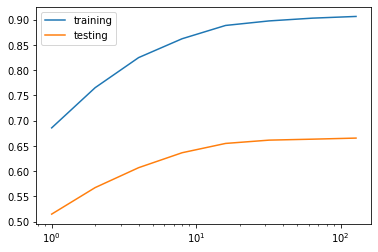

In [18]:
n_max = 8
Err_Train = np.zeros(n_max)
Err_Test = np.zeros(n_max)
indices = 2**np.array(range(0,n_max))
for i in range(n_max):
    #==========Write your code below=====

    clf = BaggingClassifier(base_estimator=tree, n_estimators=indices[i], random_state=0).fit(X_train, y_train)
    Err_Train[i] = accuracy_score(clf.predict(X_train), y_train)
    Err_Test[i] = accuracy_score(clf.predict(X_test), y_test)
    print("Training accuracy with i = ", i, ":", Err_Train[i])
    print("Testing  accuracy with i = ", i, ":", Err_Test[i])
    
    #================================


plt.semilogx(indices,Err_Train, label = "training")
plt.semilogx(indices,Err_Test, label = "testing")
plt.legend()

## Your response here:
1. Describe the trend you see in the plot. Do you eventually obtain a better testing accuracy than a single decision tree?<br>
The training and testing accuracy increase with respect to number of estimators.<br>
The decision tree accuracy is 0.83 for training and 0.591 for testing. With Bagging, we have accuracy as 0.66 when i = 7. Thus, we eventually obtain a better testing accuracy than a single decision tree.<br>
2. Compare the testing accuracy of bagging when i = 1 and the decision tree above. Which is greater, and why?<br>
Testing  accuracy with i =  1 is 0.5674230723535701. While the test accuracy for decision tree is 0.591. The accuracy of decision tree is greater. This is because bagging uses weaker classifier and in this case, even if we use two weak clssifier, it still doesn't work well. 

## 2. Adaboost.

Decision trees with small maximum depth won't give us good performance because of limited complexity. In this problem, we use adaboost algorithm to reduce the bias of the model and hopefully this will give us better performance. Use decision trees with maximum depth 10, 20, 50, 100 as your base classifiers (other parameters remain the same as the decision tree in Problem 1). Try [Adaboost algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) with number of iterations (the 'n_estimators' parameter in AdaBoost) in the following set:

$$T = \{ 2^i | i = 0, 1, ..., 9\}$$

Plot your training and testing error and 
1. Explain the trend in your plots. 
2. After training accuracy reaches 1, does testing accuracy still increase? Does it contradict with your original conception?

Number of Weak Classifiers:  1
Boosting - Train accuracy  0.47156168847701
Boosting - Test accuracy  0.4357847213971724
Number of Weak Classifiers:  2
Boosting - Train accuracy  0.4019043739497938
Boosting - Test accuracy  0.330640370678389
Number of Weak Classifiers:  4
Boosting - Train accuracy  0.45740618157747337
Boosting - Test accuracy  0.36592610193655695
Number of Weak Classifiers:  8
Boosting - Train accuracy  0.5907123580630378
Boosting - Test accuracy  0.4374480218605204
Number of Weak Classifiers:  16
Boosting - Train accuracy  0.6771220530576914
Boosting - Test accuracy  0.47914934062017345
Number of Weak Classifiers:  32
Boosting - Train accuracy  0.7595600590661439
Boosting - Test accuracy  0.522632767019128
Number of Weak Classifiers:  64
Boosting - Train accuracy  0.8197464229339579
Boosting - Test accuracy  0.5621955566116194
Number of Weak Classifiers:  128
Boosting - Train accuracy  0.8620601863638678
Boosting - Test accuracy  0.5885707496732803
Number of Weak Class

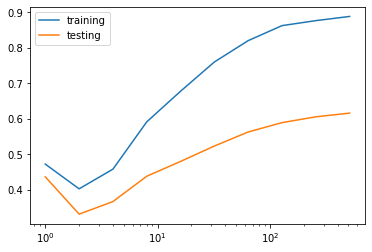

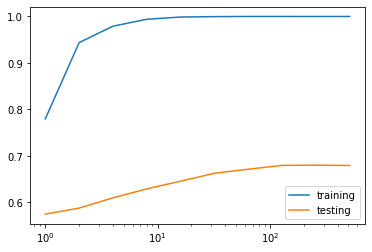

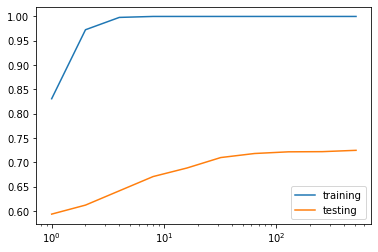

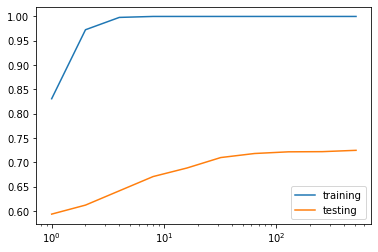

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostClassifier
n_max = 10
Err_Train = np.zeros(n_max)
Err_Test = np.zeros(n_max)
indices = 2**np.array(range(0,n_max))
depth = [10, 20, 50, 100]
for dep in depth:
    #==========Write your code below=====
    tree = DecisionTreeClassifier(max_depth= dep, min_samples_split = 3, min_samples_leaf = 2).fit(X_train, y_train)
    for i in range(n_max):
        clf = AdaBoostClassifier(base_estimator=tree, n_estimators=indices[i], random_state=0).fit(X_train, y_train)
        #Err_Train[i] = clf.score(X_train, y_train)
        #Err_Test[i] = clf.score(X_test, y_test)

        #Err_Train[i] = mean_squared_error(clf.predict(X_train), y_train)
        #Err_Test[i] = mean_squared_error(clf.predict(X_test), y_test)

        Err_Train[i] = accuracy_score(clf.predict(X_train), y_train)
        Err_Test[i] = accuracy_score(clf.predict(X_test), y_test)
        
        print("Number of Weak Classifiers: ", indices[i])
        print("Boosting - Train accuracy ", Err_Train[i])
        print("Boosting - Test accuracy ", Err_Test[i])

    #================================

    plt.figure()
    plt.semilogx(indices,Err_Train, label = "training")
    plt.semilogx(indices,Err_Test, label = "testing")
    plt.legend()

## Your response here:
1. Explain the trend in your plots.<br>
Overall, in each plot, both the training error and testing error will increase when the number of iterations increases. Even if the training accuracy reaches 1.0, the testing accuracy will keep increasing as the number of iterations increases. 
2. After training accuracy reaches 1, does testing accuracy still increase? Does it contradict with your original conception?<br>
Yes. Let's observe the accuracy results by using decision tree with depth = 50 as base. The training accuracy reaches 1.0 and its tesing accuracy increases from 0.67 to 0.72 with number of iterations = 8 to 512.

## 3. Boosting Complex Classifiers.

Using random forest with 10 trees and max_depth 50 as your base classifier, train an AdaBoost classifier with number 
of iterations from 

$$T = \{ 2^i | i = 0, 1, ..., 6\}$$

Plot the training and testing error. Explain the trend in your plot. Compared to Problem 2, is there significant improvement as you increase the number of iterations in AdaBoost? Why?

Number of Weak Classifiers:  1
Boosting - Train accuracy  0.8768267223382046
Boosting - Test accuracy  0.6428656290839967
Number of Weak Classifiers:  2
Boosting - Train accuracy  0.9619634400936912
Boosting - Test accuracy  0.6580729476060354
Number of Weak Classifiers:  4
Boosting - Train accuracy  0.9707724425887265
Boosting - Test accuracy  0.6375193061660924
Number of Weak Classifiers:  8
Boosting - Train accuracy  0.9635928509598248
Boosting - Test accuracy  0.6119757633361055
Number of Weak Classifiers:  16
Boosting - Train accuracy  0.954376495748256
Boosting - Test accuracy  0.6009266959724368
Number of Weak Classifiers:  32
Boosting - Train accuracy  0.9648658281989918
Boosting - Test accuracy  0.6219555661161934


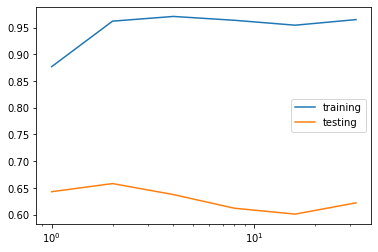

In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
n_max = 6
Err_Train = np.zeros(n_max)
Err_Test = np.zeros(n_max)
indices = 2**np.array(range(0,n_max))


tree = DecisionTreeClassifier(max_depth= 50, min_samples_split = 3, min_samples_leaf = 2).fit(X_train, y_train)
forest = BaggingClassifier(base_estimator=tree, n_estimators=10, random_state=0).fit(X_train, y_train)
for i in range(0,n_max):
    #==========Write your code below=====
    clf = AdaBoostClassifier(base_estimator=forest, n_estimators=indices[i], random_state=0).fit(X_train, y_train)
    #Err_Train[i] = clf.score(X_train, y_train)
    #Err_Test[i] = clf.score(X_test, y_test)

    Err_Train[i] = accuracy_score(clf.predict(X_train), y_train)
    Err_Test[i] = accuracy_score(clf.predict(X_test), y_test)
    print("Number of Weak Classifiers: ", indices[i])
    print("Boosting - Train accuracy ", Err_Train[i])
    print("Boosting - Test accuracy ", Err_Test[i])


    #================================

plt.semilogx(indices,Err_Train, label = "training")
plt.semilogx(indices,Err_Test, label = "testing")
plt.legend()

## Your response here:
1. Plot the training and testing error. Explain the trend in your plot. Compared to Problem 2, is there significant improvement as you increase the number of iterations in AdaBoost? Why?<br>
The accuracy is larger than that in problem 2 for the first few iterations (whose n_estimators is smaller), but after the number of weak classifiers is 8, the result becomes unstable. This means that the accuracy becomes decreases and then increases. (Which is the trend of the two curves in the plot) In other words, there is no significant improvement as increasing number of iterations in AdaBoost. This could because the forest is already so random and increase of iteration for boosting only make it the same random and couldn't make the error go down. 